In [72]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [73]:
from mini_yolov3.model import MiniYoloV3
from mini_yolov3.trainer import Trainer
import torch
from torchvision.transforms import v2
from mini_yolov3.dataset import SVHNDataset, collate_fn
from torch.utils.data import Subset, DataLoader
from mini_yolov3.loss import YOLOLoss, build_targets
import matplotlib.pyplot as plt
from mini_yolov3.utils import draw_bounding_boxes
from torchvision.ops import box_convert
from mini_yolov3.evals import calculate_mAP
from torchvision.ops import box_iou
from tqdm import tqdm

In [74]:
train_dataset = SVHNDataset(split="train")
# train_dataset = Subset(train_dataset, range(12, 13))
train_dataset = Subset(train_dataset, range(0, 2))

In [75]:
train_dataset[0]["bbox"]

tensor([[0.3551, 0.0217, 0.1963, 0.8696],
        [0.5327, 0.0652, 0.1495, 0.8696]])

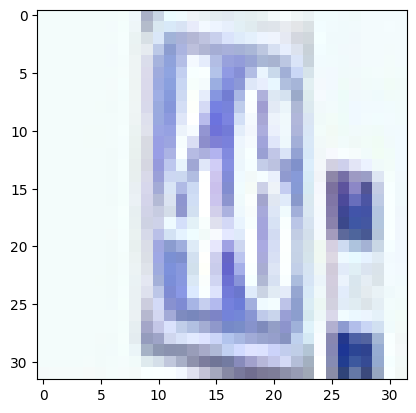

In [76]:
plt.imshow(train_dataset[0]["image"].permute(1, 2, 0))

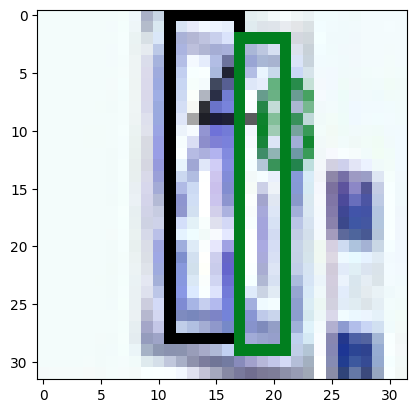

In [77]:
plt.imshow(
    draw_bounding_boxes(train_dataset[0]["image"], box_convert(train_dataset[0]["bbox"], "xywh", "xyxy"), train_dataset[0]["labels"])
)

In [78]:
dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)

In [79]:
len(dataloader)

1

In [80]:
for batch in dataloader:
    print(batch["bboxes"])
    print(box_convert(batch["bboxes"][0], "xywh", "cxcywh"))
    targets = build_targets(batch["bboxes"], batch["labels"], (2, 2), anchors, 10)

[tensor([[0.3443, 0.1290, 0.1967, 0.7419],
        [0.5082, 0.1613, 0.1639, 0.7419]]), tensor([[0.3551, 0.0217, 0.1963, 0.8696],
        [0.5327, 0.0652, 0.1495, 0.8696]])]
tensor([[0.4426, 0.5000, 0.1967, 0.7419],
        [0.5902, 0.5323, 0.1639, 0.7419]])


NameError: name 'anchors' is not defined

In [ ]:
batch["images"].shape

torch.Size([2, 3, 32, 32])

In [ ]:
import json

In [128]:
torch.manual_seed(0)

config = json.load(open("./configs/experiment2.json", "r"))
model = MiniYoloV3(**config)

trainer = Trainer(
    model=model,
    train_dataset=train_dataset,
    num_epochs=100,
    lr=3e-3,
    batch_size=64,
    lambda_coord=0.05,
    lambda_conf=1.0,
    lambda_cls=0.5,
    device="cpu",
    eval_every=100000,
)

100%|██████████| 100/100 [00:14<00:00,  6.71it/s, class_loss=0.000784, conf_loss=0.00533, coord_loss=0.000244, loss=0.00636]


[3.3581395149230957,
 3.0415985584259033,
 2.7030816078186035,
 2.349425792694092,
 2.0693459510803223,
 1.8362581729888916,
 1.6263676881790161,
 1.4461538791656494,
 1.277565836906433,
 1.1216779947280884,
 0.9794669151306152,
 0.8505647778511047,
 0.737808346748352,
 0.6383603811264038,
 0.5507615804672241,
 0.4781323969364166,
 0.41813963651657104,
 0.37555715441703796,
 0.34559351205825806,
 0.3222559690475464,
 0.3001021444797516,
 0.2779041528701782,
 0.2551753520965576,
 0.23251762986183167,
 0.21480625867843628,
 0.2015937715768814,
 0.18855533003807068,
 0.176982581615448,
 0.16963154077529907,
 0.16362205147743225,
 0.15840327739715576,
 0.1543312966823578,
 0.14930549263954163,
 0.14349471032619476,
 0.1374928504228592,
 0.1309647411108017,
 0.12392158806324005,
 0.11643551290035248,
 0.1091652363538742,
 0.09869401156902313,
 0.08538655936717987,
 0.07460009306669235,
 0.06848759949207306,
 0.06345947831869125,
 0.059367354959249496,
 0.05481798201799393,
 0.05116542428731

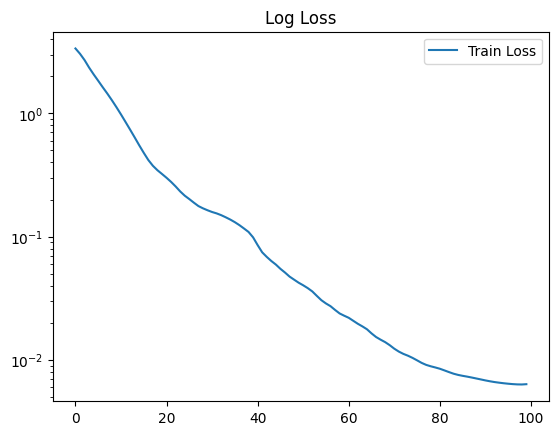

In [129]:
trainer.train()

In [130]:
pred = model(batch["images"])
pred

[tensor([[[[ 3.9268e+00, -1.8802e+00,  1.4177e+00,  2.1544e+00, -4.0445e+00,
            -2.4687e+00,  7.1440e-01,  1.7345e+00,  2.9588e-01, -2.2963e+00,
            -2.4164e+00, -3.2378e-01, -1.8908e+00, -3.0316e-02, -1.0034e+00],
           [ 2.2617e-01, -5.9119e+00,  1.5011e+00,  9.3422e-01, -5.5146e+00,
            -3.9996e+00, -2.1599e-01, -1.2056e+00, -3.1691e+00, -4.5643e+00,
            -4.3128e+00,  4.1944e-01,  7.1870e-01, -5.2345e+00, -1.5977e+00],
           [ 3.8512e+00, -2.9216e+00,  2.4157e+00,  2.7372e+00, -5.6175e+00,
            -2.8067e+00,  7.7296e-01,  2.0146e+00, -1.0889e+00, -3.7511e+00,
            -2.5307e+00,  6.0420e-01, -1.4164e+00, -1.8540e+00, -1.1628e+00],
           [ 3.4876e-01, -3.2443e+00,  1.1648e+00,  1.2041e+00, -4.6647e+00,
            -2.0121e+00, -4.1404e-01, -3.8360e-01, -1.8476e+00, -2.3631e+00,
            -1.4657e+00,  3.0923e-01,  5.4386e-01, -3.3139e+00, -7.4084e-02]],
 
          [[ 4.2486e+00, -1.9652e+00,  1.5068e+00,  2.3373e+00, -4.33

In [135]:
i = 0

In [136]:
output = model.inference(
    batch["images"],
)

bounding_boxes = output.bboxes
bounding_boxes

[{'bboxes': tensor([[0.5913, 0.5306, 0.1659, 0.7584],
          [0.4439, 0.5000, 0.1960, 0.7315]]),
  'confidence': tensor([0.9997, 0.9937]),
  'labels': tensor([1, 7]),
  'scores': tensor([1.0000, 1.0000])},
 {'bboxes': tensor([[0.4536, 0.4577, 0.1967, 0.8874],
          [0.6054, 0.5000, 0.1510, 0.8616]]),
  'confidence': tensor([1.0000, 0.9948]),
  'labels': tensor([4, 6]),
  'scores': tensor([1.0000, 0.9999])}]

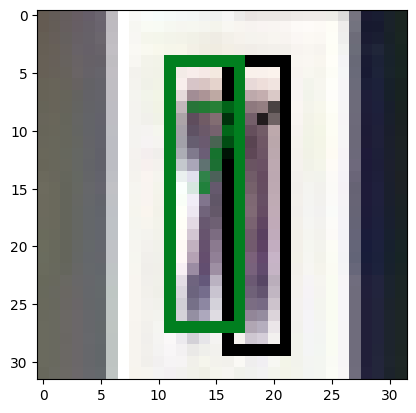

In [137]:
plt.imshow(
    draw_bounding_boxes(batch["images"][i],
                        box_convert(
                            bounding_boxes[i]["bboxes"], 
                            "cxcywh",
                            "xyxy"
                        ), 
                        bounding_boxes[i]["labels"]
)
)

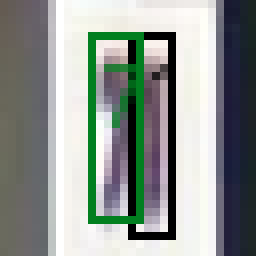

In [138]:
draw_bounding_boxes(batch["images"][i],
                        box_convert(
                            bounding_boxes[i]["bboxes"], 
                            "cxcywh",
                            "xyxy"
                        ), 
                        bounding_boxes[i]["labels"]
).resize((256, 256), 0)

In [127]:
calculate_mAP(
    model,
    trainer.train_loader,
)

{'map': 0.75,
 'map_50': 1.0,
 'map_75': 1.0,
 'map_small': 0.75,
 'map_medium': -1.0,
 'map_large': -1.0,
 'mar_1': 0.75,
 'mar_10': 0.75,
 'mar_100': 0.75,
 'mar_small': 0.75,
 'mar_medium': -1.0,
 'mar_large': -1.0,
 'map_per_class': -1.0,
 'mar_100_per_class': -1.0,
 'classes': [1, 4, 6, 7]}